Initializing libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
from xgboost import XGBClassifier

Loading datasets

In [92]:
df = pd.read_csv("kepler1.csv", comment='#')


Data Processing

In [93]:
print(df.columns.tolist())


['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen', 'koi_longp', 'koi_impact', 'koi_duration', 'koi_ingress', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_fittype', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor', 'koi_limbdark_mod', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_parm_prov', 'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_quarters', 'koi_bin_oedp_sig', 'koi_trans_mod', 'koi_model_dof', 'koi_model_chisq', 'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_sage', 'koi_sparprov', 'ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 

In [94]:
base_features = [
    # --- Orbital characteristics ---
    'koi_period',        # Orbital period (days)
    'koi_time0bk',       # Transit epoch (start time)
    'koi_duration',      # Transit duration (hours)
    'koi_depth',         # Transit depth (ppm)
    'koi_impact',        # Impact parameter

    # --- Planetary characteristics ---
    'koi_prad',          # Planetary radius (Earth radii)
    'koi_teq',           # Equilibrium temperature (K)
    'koi_insol',         # Insolation flux (Earth flux)

    # --- Stellar characteristics ---
    'koi_steff',         # Stellar effective temperature (K)
    'koi_slogg',         # Stellar surface gravity (log10(cm/s²))
    'koi_srad',          # Stellar radius (Solar radii)

    # --- Observation / signal quality ---
    'koi_model_snr',     # Transit signal-to-noise
    'koi_kepmag',        # Kepler-band magnitude (brightness)
    'ra',                # Right ascension
    'dec'                # Declination
]

df["planet_star_radius_ratio"] = df["koi_prad"] / df["koi_srad"]
df["insolation_temp_ratio"] = df["koi_insol"] / df["koi_teq"]
df["log_period"] = np.log1p(df["koi_period"])
df["log_snr"] = np.log1p(df["koi_model_snr"])
# df["depth_duration_ratio"] = df["koi_depth"] / df["koi_duration"]
df["depth_duration_ratio"] = df["koi_depth"] / (df["koi_duration"] + 1)
df["radius_insolation_ratio"] = df["koi_prad"] / (df["koi_insol"] + 1)
df["temp_ratio"] = df["koi_teq"] / (df["koi_steff"] + 1)
df["signal_strength"] = df["koi_model_snr"] * df["koi_depth"]

features = base_features + [
    "planet_star_radius_ratio",
    "insolation_temp_ratio",
    "log_period",
    "log_snr",
    "depth_duration_ratio",
    "temp_ratio",
    "radius_insolation_ratio",
    "signal_strength"
]

In [122]:
target = "koi_disposition"

df = df[features + [target]].dropna()

X = df[features]
y = df[target]

X = X.fillna(X.median(numeric_only=True))

le = LabelEncoder()
y = le.fit_transform(y)


print("Classes:", le.classes_)
print(df.shape)

Classes: ['CANDIDATE' 'CONFIRMED' 'FALSE POSITIVE']
(9200, 24)


Training Model

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from collections import Counter

# --- 1️⃣ Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2️⃣ Compute class weights ---
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), weights))

# --- 3️⃣ Apply SMOTE on training data only ---
class_counts = Counter(y_train)
majority = max(class_counts.values())

target_counts = {
    0: int(0.8 * majority),  # class 0 → FALSE POSITIVE
    1: int(0.9 * majority),  # class 1 → CANDIDATE
    2: majority              # class 2 → CONFIRMED
}
sm = SMOTE(sampling_strategy=target_counts, random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_resampled))

# --- 4️⃣ Map sample weights for resampled data ---
sample_weights = np.array([class_weights[label] for label in y_resampled])

# --- 5️⃣ Train model ---

model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=3,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)

model.fit(X_resampled, y_resampled)

# --- 6️⃣ Evaluate ---
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Before SMOTE: [1500 2195 3665]
After SMOTE: [2932 3298 3665]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       375
           1       0.83      0.85      0.84       549
           2       0.87      0.78      0.82       916

    accuracy                           0.78      1840
   macro avg       0.75      0.76      0.75      1840
weighted avg       0.79      0.78      0.78      1840



Evaluation

Accuracy: 0.7760869565217391

Classification Report:
                 precision    recall  f1-score   support

     CANDIDATE       0.55      0.66      0.60       375
     CONFIRMED       0.83      0.85      0.84       549
FALSE POSITIVE       0.87      0.78      0.82       916

      accuracy                           0.78      1840
     macro avg       0.75      0.76      0.75      1840
  weighted avg       0.79      0.78      0.78      1840



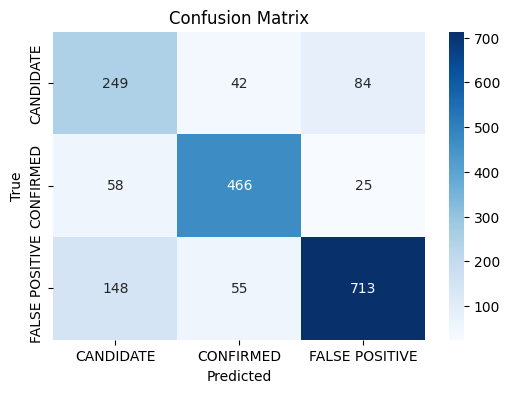

In [126]:
y_pred = model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Saving Model

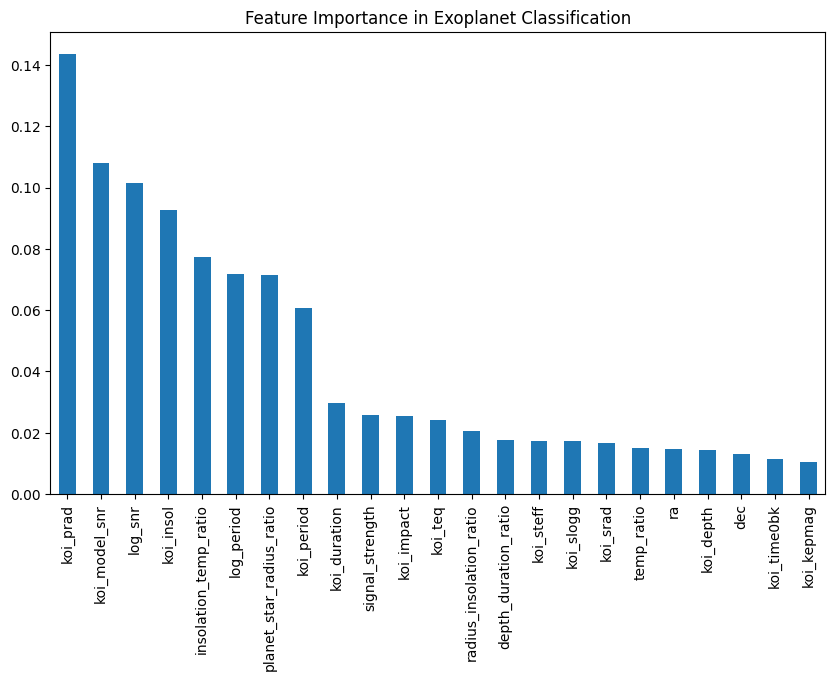

In [99]:
feat_importance = pd.Series(model.feature_importances_, index=X.columns)
feat_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Feature Importance in Exoplanet Classification")
plt.show()

In [100]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)